In [90]:
include("/home/pablo/Biofilms/scripts/biofilm_surface_growth/surface_functions.jl")

interface_deriv (generic function with 1 method)

# Biofilm height growth - nutrient arguments 

Biofilms are qualitatively and quantitatively different forms of life than their planktonic counterparts. When observing growth curves, there is an **early** ($<5h$) regime where it behaves exponential, but then it slows down.

My hipothesis is that this is an effect of nutrient dynamics (**not availability!**), the fact that there is a defined interface between the nutrient-rich location, the LB-agar, and the nutrient expenders, the biofilm growing attached to the surface.

This *should* explain:
1. the $z(t)$ dynamics (when we add a death term, no spores)
2. the change between exponential to linear growth
3. $\dot{z}(t) = F(z)$

As the *best* benchmark for this kind of biofilm-nutrient dynamics we can use as reference the work from [Srinivasan et al. (2019)](https://elifesciences.org/articles/42697) and [Fei et al. (2020)](https://www.pnas.org/content/117/14/7622.abstract).

For biofilms, the population growth term and nutrient uptake, respectively are:

$g_1(h, c, \phi) = G h \phi \frac{c}{K + c} \left(1 - \frac{h \phi}{H \phi_0} \right) \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad g_2(h, c, \phi) = \frac{\Gamma \phi h}{d} \frac{c}{K + c}$

Here, we note the prevalence of planktonic growth dynamics, since the term $h \phi \left(1 - \frac{h \phi}{H \phi_0} \right)$ is not even discussed on the derivation. Regardless, we can try to simplify the model as much as possible in order to see if the predictions *fit* in our height measurements.

$\dot{b} = \alpha b \frac{c}{K_{c} + c} \left(1-\frac{b}{K_b}\right) \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \dot{c} = \beta b \frac{c}{K_{c}+c}$

$\dot{b} = G(b)*\frac{c}{K_{c} + c} - \beta*b$

**Note**: a logistic uptake was also my assumption on the first biomass model iteration!

## I. Nutrient-dependent, logistic and interface limited models

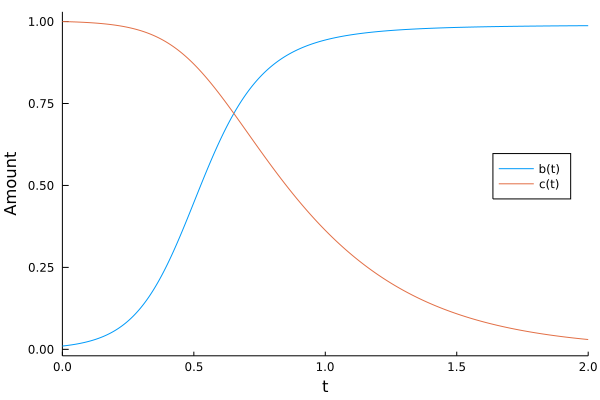

In [91]:
nl_sol = nutrient_limited()
plot(nl_sol, grid=false, legend=:right, ylabel="Amount")

Looks reasonable! **Unless** you have actually taken height timelapses and seen that this is **not how it looks!**. The model curve $b(t)$ is symmetric and it reaches equilibrium quite fast, in real biofilms there's a long period in which it grows linearly. Here we'll load radial profiles and compare how the height in the homeland ~$b(t)$ compares to the model. Still, the way the nutrient concentration decays is better than I had, should definitely look into it.

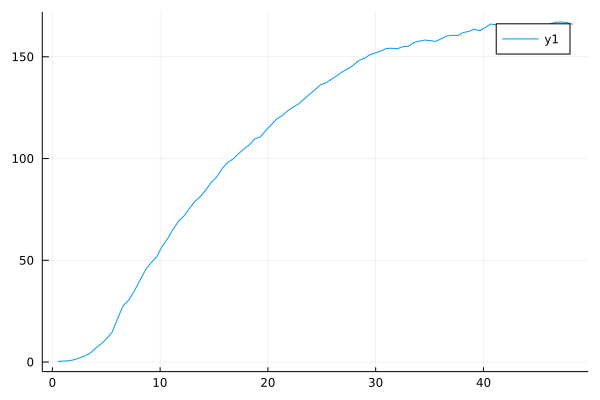

In [92]:
t_experiment, h_experiment = experimental_heights("SN503", "A")
plot(t_experiment, h_experiment)

In [93]:
tspan = (0.0, 72.0)
tags = ["Early", "Middle", "Late"]
u0 = [[b => 0.5, c => 10], [b => 9, c => 10], [b => 10, c => 10]]
p = [[α => 1.95, β => 0.01, Kb => 167.0, Kc => 21],
     [α => 2.5, β => 0.01, Kb => 135.0, Kc => 100],
     [α => 2.0, β => 0.01, Kb => 167.0, Kc => 100]]

p1 = plot()
Y = []
for i=1:3
     prob = ODEProblem(ODESystem(eqs),u0[i],tspan,p[i])
     sol = solve(prob, Tsit5(), saveat=0.1)
     p1 = plot!(sol, vars=b, label=tags[i], linewidth=2)
     push!(Y, reduce(hcat, sol.u)[1,:])
end
p1 = scatter!(t_experiment, h_experiment, label="Experimental", legend=:topleft, color=:black, alpha=0.5, xlim=(0, 49))

LoadError: [91mUndefVarError: b not defined[39m

But when we introduce the **saturation function** $G(x)$ we get a great fit for the data!

In [ ]:
tspan = (0.0, 72.0)
if_sol = interface_limited()
p1 = plot(if_sol, grid=false, legend=:right,xlabel="Time (h)", ylabel="Height (μm)", xlim=(0,49), vars=b, label="Saturated well", linewidth=2.5)
p1 = scatter!(t_experiment, h_experiment, label="Experimental", legend=:topleft, color=:black, alpha=0.5, dpi=100)


## II. Fitting models to the experimental data
### II.1 Dynamic Data Analysis

While in the previous section we did an *eye-fit* to the data, that obviously introduces *bias*, but it serves the purpose of introducing the behavior of the different models. As well as the obvious downfalls of the first two. 

Fitting experimental data to a dynamical system of equations is called [dynamic data analysis](https://diffeq.sciml.ai/stable/analysis/parameter_estimation/). For now we will stick to the library [DiffEqParamEstim.jl](https://diffeqparamestim.sciml.ai/dev/) because of it's ease of use. But we **should** look into alternatives that use Bayesian estimation.

**NOTE**: Currently this is a Lotka-Volterra example on how to optimize parameters

In [ ]:
using DiffEqParamEstim, Optim, RecursiveArrayTools, LeastSquaresOptim

function f(du,u,p,t)
  du[1] = dx = p[1]*u[1] - u[1]*u[2]
  du[2] = dy = -3*u[2] + u[1]*u[2]
end

u0 = [1.0;1.0]
tspan = (0.0,10.0)
p = [1.5]
prob = ODEProblem(f,u0,tspan,p)

sol = solve(prob,Tsit5())
t = collect(range(0,stop=10,length=200))
randomized = VectorOfArray([(sol(t[i]) + .01randn(2)) for i in 1:length(t)])
data = convert(Array,randomized)

function f2(du,u,p,t)
  du[1] = dx = p[1]*u[1] - p[2]*u[1]*u[2]
  du[2] = dy = -p[3]*u[2] + p[4]*u[1]*u[2]
end

u0 = [1.0;1.0]
tspan = (0.0,10.0)
p = [1.5,1.0,3.0,1.0]
prob = ODEProblem(f2,u0,tspan,p)
sol = solve(prob)
plot(sol)
t = collect(range(0,stop=10,length=200))
randomized = VectorOfArray([(sol(t[i]) + .01randn(2)) for i in 1:length(t)])
data = convert(Array,randomized)
scatter(t, data')

In [ ]:
cost_function2 = build_loss_objective(prob,Tsit5(),L2Loss(t,data),
                                      maxiters=10000,verbose=false)
result_bfgs = Optim.optimize(cost_function2, [1.3,1.0,2.8,1.1], Optim.BFGS())
Optim.minimizer(result_bfgs)

In [ ]:
prob = ODEProblem(f2,u0,tspan,Optim.minimizer(result_bfgs))
sol_guessed = solve(prob)
plot(sol_guessed, linewidth=2)
scatter!(t, data', color=:black, alpha=0.5)

### II.2 $z'$ and $z'$ fitting

The other alternative for fitting, is using the dependence on height change $z'$ with the height $z$. This simplifies greatly the problem because we don't have to integrate as we go along.

$z' = \alpha \cdot G(z) \cdot \frac{c}{K + c} - \beta \cdot z \approx \alpha \cdot G(z)- \beta \cdot z$

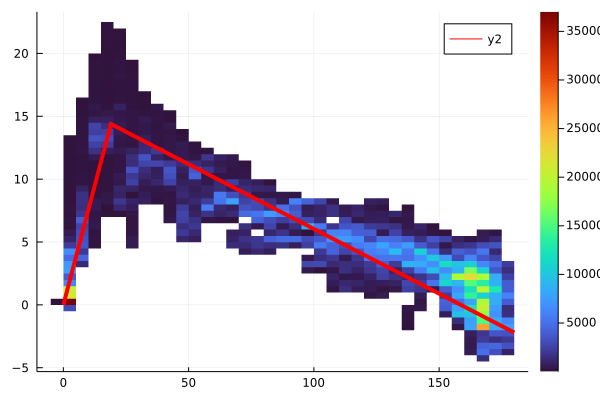

In [ ]:
df = DataFrame(Arrow.Table("/home/pablo/Biofilms/Data/radialv2.arrow"));
tf = df[(df.Strain .== "SN503") .& (df.Replicate .<= "A") , :]
h = z_histogram(tf)

z, ep = Array(0:180), [19, 0.86, 0.103]
zprime = interface_deriv(z, ep)
plot(h, c=:turbo, density=true)
plot!(z, zprime, color=:red, linewidth=4)

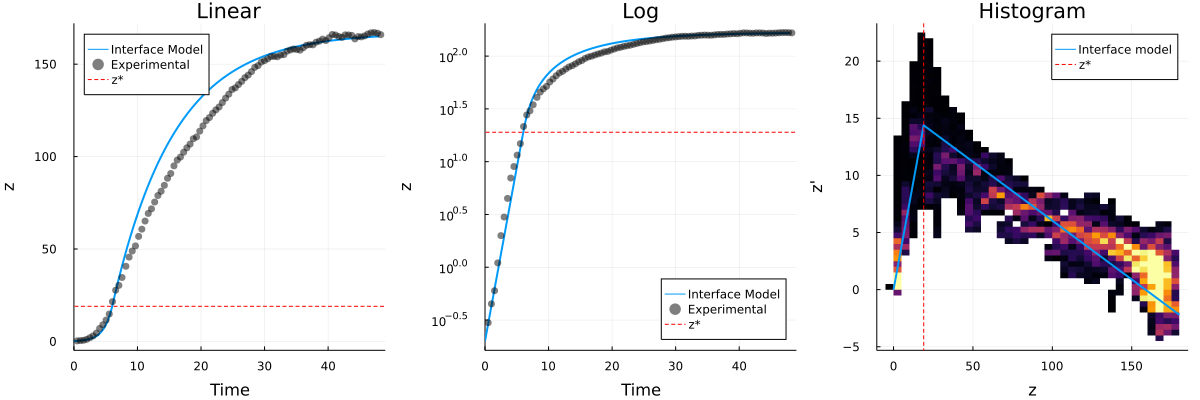

In [ ]:
@parameters t α β zstar
@variables z(t)
D = Differential(t)
eqs = [D(z) ~ α .* G(z, 20) - β*z]

#ep = [19, 0.8, 0.095]
ep = [19, 0.86, 0.103]
tspan = (0.0, 48.0)
u0 = [z => 0.2]
p  = [α => ep[2], β =>ep[3], zstar => ep[1]]
prob = ODEProblem(ODESystem(eqs),u0,tspan,p)
sol = solve(prob,Tsit5(), saveat=0.1);
p1 = plot(sol, label="Interface Model", xlabel="Time", ylabel="z", linewidth=2, title="Linear")
p1 = scatter!(t_experiment, h_experiment, label="Experimental", legend=:topleft, color=:black, alpha=0.5, xlim=(0, 49))
p1 = hline!([ep[1]], color=:red, linestyle=:dash, label="z*")
p2 = plot(sol, label="Interface Model", xlabel="Time", ylabel="z", linewidth=2, title="Log")
p2 = scatter!(t_experiment, h_experiment, label="Experimental", legend=:topleft, color=:black, alpha=0.5, xlim=(0, 49))
p2 = hline!([ep[1]], color=:red, linestyle=:dash, label="z*", yscale=:log10, legend=:bottomright)
z = Array(0:180)
zprime = interface_deriv(z, ep)
p3 = plot(h, density=true, clim=(0, 10000), colorbar=false, xlabel="z", ylabel="z'", title="Histogram")
p3 = plot!(z, zprime, color=1, linewidth=2, label="Interface model")
p3 = vline!([ep[1]], color=:red, linestyle=:dash, label="z*")
plot(p1, p2, p3, layout=@layout([a b c]), size=(1200, 400), left_margin=5mm, bottom_margin=5mm)

In [ ]:
using LsqFit
@. model(x, p) = p[1]*exp(-x*p[2])
xdata = Array(0.0:0.1:50)
ydata = model(xdata, [1.0 2.0]) + 0.01*randn(length(xdata))
p0 = [0.5, 0.5]
fit = curve_fit(model, xdata, ydata, p0)

## Shapes and a single-cell biofilm

To think about shapes we need the key ingredient of a spatial variable $\vec{x}$, if we keep the assumption that $c\rightarrow \infty$, then the system can be written as:


Now that we found a good set of parameters for $\alpha$ and $\beta$, we are only lacking one parameter for spatial growth: the lateral growth or diffusion $D$. To find this value, we go back at our Dataframe and profiles

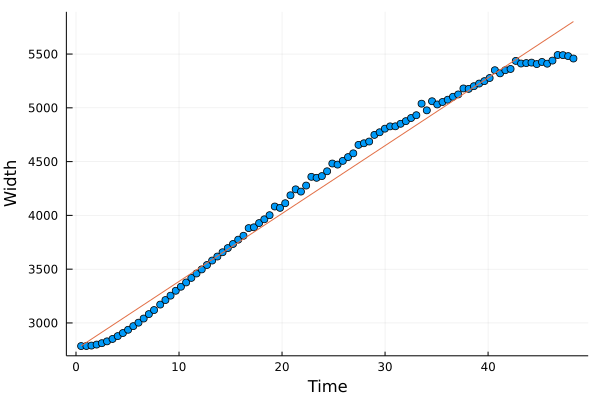

In [ ]:
using Polynomials
df = DataFrame(Arrow.Table("/home/pablo/Biofilms/Data/radialv2.arrow"));
tf = df[(df.Strain .== "SN503") .& (df.Replicate .<= "A") , :];
scatter(tf.Time, tf.W*1000, label=false, xlabel="Time", ylabel="Width")
myfit = Polynomials.fit(tf.Time, tf.W*1000, 1)
plot!(tf.Time, myfit[0] .+ tf.Time*myfit[1], label=false)

In [ ]:
myfit[1]

63.11024784763018

In [ ]:
using DifferentialEquations, DiffEqOperators

function biofilm(u0, x, pars, tspan)
    α, β, ν, ucrit= pars
    Δ = CenteredDifference(2, 2, x[2], length(x))
    bc = PeriodicBC(Float64)
    f(u,p,t) =  ν*Δ*bc*u + α*G.(u, ucrit) - β*u
    return ODEProblem(f, u0, (tspan[1], tspan[end]))
end

biofilm (generic function with 1 method)

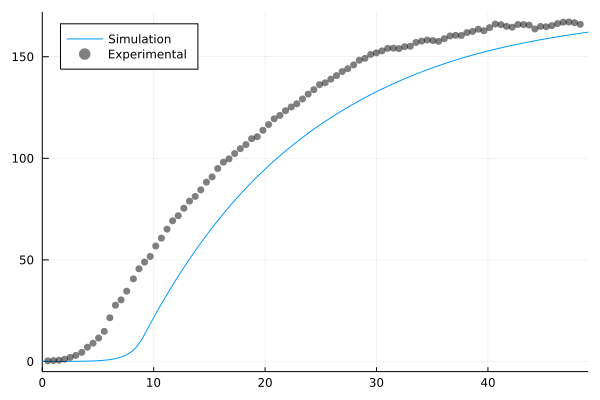

In [ ]:
x = Array(0:0.1:2000.0)             # x-dimension
gaussian(x, p) = 1/p[1] * exp.(-((x .- p[2])/p[1]).^2)
u0 = gaussian(x, [1, 1000])
u0[u0 .< 0.005] .= 0
pars = [1.0, 0.069, 63.0, 12.0]            
t = Array(0:0.5:50)                # Time range
prob = biofilm(u0 ./ 8, x, pars, t)
sol = solve(prob, saveat=t[2]);
mids = [x[10000] for x in sol.u]
plot(sol.t, mids, label="Simulation")
scatter!(t_experiment, h_experiment, label="Experimental", legend=:topleft, color=:black, alpha=0.5, xlim=(0, 49))

┌ Info: Saved animation to 
│   fn = /home/pablo/Biofilms/scripts/biofilm_surface_growth/figs/single_cell.gif
└ @ Plots /home/pablo/.julia/packages/Plots/yiUpW/src/animation.jl:104


Plots.AnimatedGif("/home/pablo/Biofilms/scripts/biofilm_surface_growth/figs/single_cell.gif")
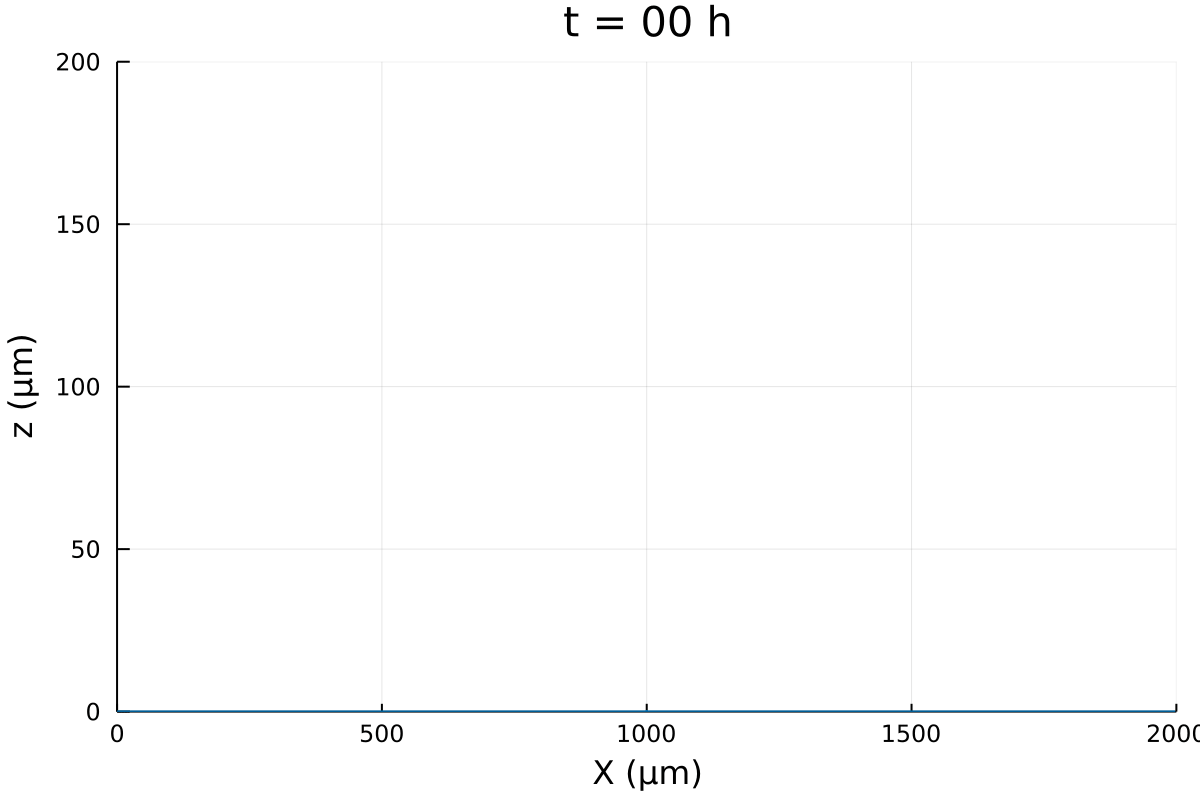

In [130]:
ind = Array(1:20:20000)
simple_t = string.("t = ", lpad.(Int.(floor.(sol.t)), 2, "0"), " h")
anim = @animate for i=1:(length(sol.t))
    plot(x[ind], sol.u[i][ind], title=simple_t[i], label=false, ylim=(0, 200), xlim=(000, 2000), dpi=200, xlabel="X (μm)", ylabel="z (μm)")#, size=(800, 200))
end
gif(anim, "/home/pablo/Biofilms/scripts/biofilm_surface_growth/figs/single_cell.gif", fps = 15)


In [109]:
sol.t

101-element Array{Float64,1}:
  0.0
  0.5
  1.0
  1.5
  2.0
  2.5
  3.0
  3.5
  4.0
  4.5
  5.0
  5.5
  6.0
  ⋮
 44.5
 45.0
 45.5
 46.0
 46.5
 47.0
 47.5
 48.0
 48.5
 49.0
 49.5
 50.0

In [129]:
simple_t = string.("t = ", lpad.(Int.(floor.(sol.t)), 2, "0"), " h")

101-element Array{String,1}:
 "t = 00 h"
 "t = 00 h"
 "t = 01 h"
 "t = 01 h"
 "t = 02 h"
 "t = 02 h"
 "t = 03 h"
 "t = 03 h"
 "t = 04 h"
 "t = 04 h"
 "t = 05 h"
 "t = 05 h"
 "t = 06 h"
 ⋮
 "t = 44 h"
 "t = 45 h"
 "t = 45 h"
 "t = 46 h"
 "t = 46 h"
 "t = 47 h"
 "t = 47 h"
 "t = 48 h"
 "t = 48 h"
 "t = 49 h"
 "t = 49 h"
 "t = 50 h"

In [120]:
@printf("%03d\n", 4)

LoadError: LoadError: [91mUndefVarError: @printf not defined[39m
in expression starting at In[120]:1

In [94]:
string()

4